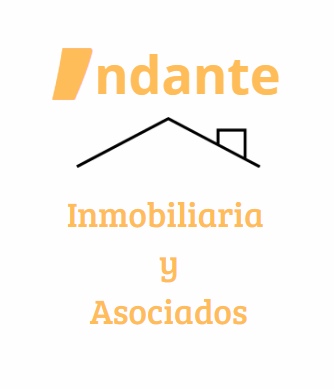

El presente análisis pretende mostrar las variables que más afectan al precio de la vivienda. Inicialmente se realizará una visión generalizada de los datos disponibles, después se realizará la limpieza de datos correspondiente para, finalmente, obtener un modelo de predicción lo más preciso posible.

Los datos utilizados proceden del siguiente link de Kaggle:  
https://www.kaggle.com/datasets/mirbektoktogaraev/madrid-real-estate-market

# 1- ANÁLISIS DE PRECIOS DE VIVIENDA

## 1. PREPARACIÓN DEL ENTORNO

### Importar librerias

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Guardar modelo de predicción
#from sklearn.externals import joblib

### Cargar datos

In [2]:
# Carga de datos
data = pd.read_csv("/content/houses_Madrid1.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/houses_Madrid1.csv'

### Visualización de datos principales

In [ ]:
# Tamaño de datos
data.shape

In [ ]:
# Primeros resultados
data.head()

In [ ]:
# Últimos resultados
data.tail()

In [ ]:
# Columnas, nulos y tipo de datos
data.info()

In [ ]:
# Valores estadísticos
data.describe()

## 2. LIMPIEZA DE LOS DATOS

### 1. Comprobar duplicados

In [ ]:
# Comprobar si hay valores duplicados
duplicados_columnas = data.duplicated(subset='id')
duplicados_columnas

En el dataset no hay filas duplicadas, por lo que todos los registros son únicos.

### 2. Comprobar nulos

In [ ]:
# Comprobar porcentaje de nulos por columna
columnas_con_nulos = [i for i in data.columns if data[i].isnull().sum() > 0]
for col in columnas_con_nulos:
    print(col, (data[col].isnull().sum() / duplicados_columnas.count() * 100).round(2), '% de nulos')

Como vemos, tenemos columnas con varios registros faltantes. En el siguiente apartado trataremos éstas columnas.

### 3. Tratamiento de columnas con nulos.

Para la correción de las columnas, vamos a seguir los siguientes criterios:

*** Columnas con todo nulos:** Eliminación del dataset ya que no aportan nada de información.  
*** Columnas irrelevantes:** Eliminación del dataset por aportar información redundante o poco relevante para el análisis.  
*** Columnas con datos faltantes:** Se completarán los datos faltantes con diferentes criterios que se explicarán en cada una de las variables.

### Eliminar columnas con el 100% de nulos:

In [ ]:
# Eliminar columnas sin datos
data = data.drop(
    columns = ['sq_mt_useful','n_floors','sq_mt_allotment','latitude',
               'longitude','raw_address', 'street_number', 'street_name',
               'portal', 'door','rent_price_by_area','house_type_id',
               'has_central_heating','has_individual_heating','are_pets_allowed',
               'has_fitted_wardrobes','has_garden','is_furnished',
               'is_kitchen_equipped','has_private_parking','has_public_parking',
               'is_parking_included_in_price', 'parking_price','is_orientation_north',
               'is_orientation_west','is_orientation_south','is_orientation_east']
)

### Eliminar columnas irrelevantes:

In [ ]:
# Eliminar colummnas irrelevantes
data = data.drop(
    columns = ['Unnamed: 0','id','is_exact_address_hidden',
               'is_floor_under','neighborhood_id','operation',
               'rent_price','is_rent_price_known', 'buy_price_by_area',
               'is_buy_price_known','is_exterior','energy_certificate']
    )

### Tratar columnas con datos faltantes

En este apartado vamos a completar y ajustar las columnas que consideramos más relevantes para el análisis, que son las siguientes 18:

In [ ]:
# Visualizar columnas actuales
data.columns

#### Número de baños (n_bathrooms)

Tras analizar los datos de esta columna, llegamos a la conclusión de que las viviendas siguen el criterio de tener los mismos baños que habitaciones menos 1, salvo que sólo tengan una habitación o ninguna (caso de los estudios), tienen un baño igualmente. Es por eso que seguiremos este criterio para completar esta columna.

In [ ]:
# Valores actuales de los baños
data["n_bathrooms"].unique()

In [ ]:
# Graficamos para visualizar mejor la relación entre baños y habitaciones
sns.barplot(data = data, x= 'n_bathrooms', y= 'n_rooms', color="#FFBD59")
plt.title('Distribución de baños en funcion de habitaciones')
plt.xlabel('n_bathrooms')
plt.ylabel('n_rooms')
plt.show()

In [ ]:
# Función para rellenar datos según el criterio indicado
def fill_bathrooms(row):
    if pd.isnull(row['n_bathrooms']):
        if (row['n_rooms'] == 1) | (row['n_rooms'] == 0):
            return 1
        else:
            return row['n_rooms'] - 1
    return row['n_bathrooms']

In [ ]:
# Aplicar función a los datos
data['n_bathrooms'] = data.apply(fill_bathrooms, axis=1)

In [ ]:
# Convertir valores a entero
data['n_bathrooms'] = data['n_bathrooms'].round().astype(int)

In [ ]:
# Comprobar los valores actuales
data['n_bathrooms'].unique()

#### Altura de pisos (floor)

Esta variable tiene múltiples valores, por lo que trataremos de englobar todos ellos en 3 tipos (0, 1, 2) pra facilitar el tratamiento del mismo.

In [ ]:
# Valores actuales de la altura de los pisos
data['floor'].unique()

In [ ]:
# Mapeo para convertir los valores en los indicados anteriormente
data["floor"] = data["floor"].map(
        {
        'Bajo': 0,
        'Entreplanta':0,
        'Entreplanta exterior': 0,
        'Entreplanta interior': 0,
        'Semi-sótano': 0,
        'Semi-sótano exterior': 0,
        'Semi-sótano interior': 0,
        'Sótano': 0,
        'Sótano exterior': 0,
        'Sótano interior': 0,
        '3': 1,
        '4': 2,
        '1': 1,
        '2': 1,
        '7':2,
        '6': 2,
        '5': 2,
        '9':2,
        '8': 2,
        'nan' : 'NaN'
    }
)

In [ ]:
# Visualizamos los datos actuales
sns.countplot(data = data, x= 'floor', color="#FFBD59")
plt.title('Distribución de la Altura de los pisos')
plt.xlabel('Altura de piso')
plt.ylabel('Cantidad')
plt.show()

Tras haber realizado esta conversión, ahora toca rellenar los valores faltantes. En esta variable, el criterio a utilizar será el de la mediana, ya que consideramos que es la mejor forma que no distorsione los datos con respecto a los que sí disponemos.

In [ ]:
# Calcular mediana
median_floor_by_subtitle = data.groupby('subtitle')['floor'].median()

In [ ]:
# Función para rellenar los valores faltantes con la mediana
def fill_na_with_median(row):
    if pd.isna(row['floor']):
        return median_floor_by_subtitle[row['subtitle']]
    else:
        return row['floor']

In [ ]:
# Aplicar la función
data['floor'] = data.apply(fill_na_with_median, axis=1)

In [ ]:
# Convertir valor a entero
data['floor'] = data['floor'].round().astype(int)

#### Ascensor (has_lift)

Esta variable vamos a completarla según la media de cada zona, para tratar de representar los mejor posible los datos reales.

In [ ]:
# Comprobar los valores únicos
data["has_lift"].unique()

In [ ]:
# Calcular la media agrupada por zona
proporcion_con_ascensor = data.groupby(
    'subtitle')['has_lift'].mean()

# Filtrar el valor para completar
zona_a_valor = proporcion_con_ascensor > 0.5

In [ ]:
# Aplicar función para completar valores
data['has_lift'] = data.apply(
    lambda row: zona_a_valor[row['subtitle']]
        if pd.isna(row['has_lift'])
        else row['has_lift'], axis=1
)

In [ ]:
# Visualizar los datos
sns.countplot(data = data, x = 'has_lift', color="#FFBD59")
plt.title('Distribución del Ascensor')
plt.xlabel('Ascensor')
plt.ylabel('Cantidad')
plt.show()

#### Variables secundarias: Tiene piscina (has_pool), tiene terraza (has_terrace), tiene balcón (has_balcony), tiene trastero (has_storage_room), accesibilidad (is_accessible), zons verdes (has_green_zones) y aire acondicionado (has_ac)

Estas columnas vienen únicamente con el valor de true y nan, por lo que asumimos que los datos faltantes corresponden a false, esto es, que no lo incluyen.

In [ ]:
# Comprobación de datos actuales
data["has_pool"].unique()

In [ ]:
# Completar datos faltantes con false
data[['has_pool', 'has_terrace', 'has_balcony', 'has_storage_room', 'is_accessible', 'has_green_zones', 'has_ac']] = data[
['has_pool', 'has_terrace', 'has_balcony', 'has_storage_room', 'is_accessible', 'has_green_zones', 'has_ac']].fillna(False)

#### Año de construcción (built_year)

El criterio a utilizar en esta variable será el de la moda.

In [ ]:
# Calcular moda
moda_año_construccion = data['built_year'].mode()[0]

In [ ]:
# Rellenar los datos faltantes con la moda
data['built_year'].fillna(moda_año_construccion, inplace=True)

In [ ]:
# Convertir valor a entero
data['built_year'] = data['built_year'].round().astype(int)

In [ ]:
# Visualizar los datos
sns.histplot(data=data, x='built_year', bins=30, kde=True, color="#FFBD59")
plt.title('Distribución de Años de Construcción')
plt.xlabel('Año de Construcción')
plt.ylabel('Frecuencia')
plt.show()

#### Nueva construcción (is_new_development)

Oficialmente, una vivienda se considera de nueva construcción cuando tiene menos de 10 años, por lo que este será el criterio a seguir para completar los datos faltantes respecto a 2024.

In [ ]:
# Función para rellenar los datos según el criterio indicado
data['is_new_development'] = data.apply(
    lambda row: True if pd.notna(row['built_year']) and 2014 <= row['built_year'] <= 2024 else
                False if pd.notna(row['built_year']) and row['built_year'] < 2014 else
                row['is_new_development'],
    axis=1
)

#### Tipo de vivienda (title)

Debido a la variedad del tipo de viviendas que existen y la disparidad de características que presentan entre ellas, hemos decidido quedarnos únicamente con los pisos y estudios, ya que los cosideramos los más uniformes para el análisis.

In [ ]:
# Ver valores actuales
data['title'].unique()

In [ ]:
# Seleccionar únicamente los valores de piso y estudio
data = data[data['title'].str.contains('Piso|Estudio', case=False, na=False)]

In [ ]:
# Una vez filtrados los datos, borramos la columna
data = data.drop(
    columns = ['title']
)

#### Descripción de la zona (subtitle)

De esta columna nos quedaremos sólo con el distrito, que es el dato que nos interesa para el análisis.

In [ ]:
# Separar en dos columnas, por zona o ciudad
data_dividido = data['subtitle'].str.split(',', expand=True)

In [ ]:
# Nombramos las nuevas columnas
data_dividido.columns = ['zona', 'ciudad']

In [ ]:
# Sustituimos la nueva columna en el dataset
data['subtitle'] = data_dividido['zona']

In [ ]:
# Renombrar nueva columna como zona
data = data.rename(columns={'subtitle': 'zona'})

Ahora, tras esta transformación, vamos a simplificar los diferentes datos de las zonas por distritos, para reducir el número de valores de la columna y así facilitar el análisis.

In [ ]:
# Ver valores únicos
data['zona'].nunique()

In [ ]:
# Mapear la columna zona con el número de distrito
data["zona"] = data["zona"].map(
     {
    'San Cristóbal': 17,
    'Los Ángeles': 17,
    'San Andrés': 17,
    'Los Rosales': 17,
    'Villaverde': 17,
    'Butarque': 17,
    'Vicálvaro': 19,
    'Ambroz': 19,
    'Casco Histórico de Vicálvaro': 19,
    'El Cañaveral - Los Berrocales': 19,
    'Valdebernardo - Valderribas': 19,
    'Casco Histórico de Vallecas': 18,
    'Villa de Vallecas': 18,
    'Ensanche de Vallecas - La Gavia': 18,
    'Santa Eugenia': 18,
    'Orcasitas': 12,
    'Usera': 12,
    'San Fermín': 12,
    'Pradolongo': 12,
    'Zofío': 12,
    'Almendrales': 12,
    'Moscardó': 12,
    '12 de Octubre-Orcasur': 12,
    'Tetuán': 6,
    'Valdeacederas': 6,
    'Berruguete': 6,
    'Cuatro Caminos': 6,
    'Cuzco-Castillejos': 6,
    'Bellas Vistas': 6,
    'Ventilla-Almenara': 6,
    'Retiro': 3,
    'Adelfas': 3,
    'Ibiza': 3,
    'Pacífico': 3,
    'Niño Jesús': 3,
    'Jerónimos': 3,
    'Estrella': 3,
    'Puente de Vallecas': 13,
    'Palomeras Bajas': 13,
    'San Diego': 13,
    'Palomeras sureste': 13,
    'Numancia': 13,
    'Entrevías': 13,
    'Portazgo': 13,
    'Aravaca': 9,
    'Argüelles': 9,
    'Valdezarza': 9,
    'Moncloa': 9,
    'Ciudad Universitaria': 9,
    'Fontarrón': 14,
    'Moratalaz': 14,
    'Vinateros': 14,
    'Marroquina': 14,
    'Media Legua': 14,
    'Pavones': 14,
    'Horcajo': 14,
    'Puerta del Ángel': 10,
    'Latina': 10,
    'Los Cármenes': 10,
    'Aluche': 10,
    'Águilas': 10,
    'Lucero': 10,
    'Campamento': 10,
    'Cuatro Vientos': 10,
    'Valdemarín': 9,
    'Casa de Campo': 9,
    'El Plantío': 9,
    'Fuencarral': 8,
    'Las Tablas': 8,
    'La Paz': 8,
    'Peñagrande': 8,
    'Tres Olivos - Valverde': 8,
    'Montecarmelo': 8,
    'Pilar': 8,
    'Mirasierra': 8,
    'Arroyo del Fresno': 8,
    'Fuentelarreina': 8,
    'El Pardo': 8,
    'Sanchinarro': 16,
    'Hortaleza': 16,
    'Virgen del Cortijo - Manoteras': 16,
    'Valdebebas - Valdefuentes': 16,
    'Palomas': 16,
    'Pinar del Rey': 16,
    'Conde Orgaz-Piovera': 16,
    'Canillas': 16,
    'Apóstol Santiago': 16,
    'Chamberí':7,
    'Almagro':7,
    'Trafalgar':7,
    'Nuevos Ministerios-Ríos Rosas':7,
    'Vallehermoso':7,
    'Gaztambide':7,
    'Arapiles':7,
    'Ventas': 15,
    'Pueblo Nuevo': 15,
    'Atalaya': 15,
    'Quintana': 15,
    'San Juan Bautista': 15,
    'Costillares': 15,
    'Ciudad Lineal': 15,
    'Concepción': 15,
    'Colina': 15,
    'San Pascual': 15,
    'Chamartín': 5,
    'El Viso': 5,
    'Prosperidad': 5,
    'Nueva España': 5,
    'Castilla': 5,
    'Bernabéu-Hispanoamérica': 5,
    'Ciudad Jardín': 5,
    'Lavapiés-Embajadores': 1,
    'Opañel': 11,
    'Comillas': 11,
    'Abrantes': 11,
    'San Isidro': 11,
    'Carabanchel': 11,
    'Puerta Bonita': 11,
    'Vista Alegre': 11,
    'Pau de Carabanchel': 11,
    'Buena Vista': 11,
    'Huertas-Cortes': 1,
    'Malasaña-Universidad': 1,
    'Chueca-Justicia': 1,
    'Palacio': 1,
    'Centro': 1,
    'Sol': 1,
    'Barrio de Salamanca': 4,
    'Goya': 4,
    'Lista': 4,
    'Guindalera': 4,
    'Fuente del Berro': 4,
    'Castellana': 4,
    'Recoletos': 4,
    'Imperial': 2,
    'Chopera': 2,
    'Acacias': 2,
    'Delicias': 2,
    'Palos de Moguer': 2,
    'Legazpi': 2,
    'Arganzuela': 2,
    'Casco Histórico de Barajas': 20,
    'Alameda de Osuna': 20,
    'Timón': 20,
    'Campo de las Naciones-Corralejos': 20,
    'Barajas': 20}
)

#### Renombrar columnas con las que me quedo

Por último, vamos renombrar todas las columnas para facilitar la comprensión:

In [ ]:
# Renombrar columnas del dataset
data.rename(columns =
            {'zona':'zona',
             'sq_mt_built':'metros_cuadrados',
             'n_rooms':'numero_habitaciones',
             'n_bathrooms':'numero_baños',
             'floor':'altura_piso',
             'buy_price':'precio_venta',
            'is_renewal_needed':'necesita_reforma',
             'built_year':'año_construccion',
             'has_ac': 'aire_acondicionado',
             'has_lift': 'ascensor',
             'has_pool' : 'piscina',
             'has_terrace':'terraza',
             'has_balcony': 'balcon',
             'is_accessible':'accesibilidad',
             'has_green_zones':'zonas_verdes',
             'has_storage_room':'trastero',
             'has_parking':'parking',
             'is_new_development':'nueva_construccion'
            },
            inplace=True)

### Comprobación de la limpieza

Ya sólo queda comprobar como han quedado los datos tras la limpieza realizada.

In [ ]:
# Visualizar primeros resultados
data.head()

In [ ]:
# Comprobar tamaño
data.shape

In [ ]:
# Comprobar tipo de datos y nulos
data.info()

Hasta aquí llega la parte de la limpieza de los datos. En el siguiente apartado comprobaremos si los criterios utilizados nos proporcionan un modelo de predicción útil para predecir precios de vivienda.

In [ ]:
# Descargar datos limpios en formato csv
#data.to_csv('excel_limpio_csv.csv', index = False)

# 2- PREDICCIÓN

En este apartado vamos a tratar de realizar un modelo de predicción en base al análisis realizado previamente. Por un lado, un Árbol de Decisión con todas las columnas, y por otro un análisis de VIF y modelo de Regresión Lineal con dos tipos de librerías y diferentes combinaciones de columnas.  
Por último, compararemos ambos modelos y nos quedaremos el que muestre mejores resultados.

### ÁRBOL DE DECISIÓN

In [ ]:
# Selección de columnas de X e y
X = data.loc[:,data.columns != 'precio_venta']
y = data.loc[:,'precio_venta']

In [ ]:
# Preparación de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size = 0.75,
    test_size = 0.25
)

In [ ]:
# Creación de modelo, entrenamiento y predicción
decission_tree = DecisionTreeClassifier()
decission_tree.fit(X_train, y_train)
y_pred = decission_tree.predict(X_test)
score_tree = round(decission_tree.score(X_train, y_train) * 100, 2)
score_tree

### REGRESIÓN LINEAL

### Preparacion de la data para el modelo

#### Convertir columnas true/false en 1 y 0

In [ ]:
# Convertir variables
columnas_true_false = data[['necesita_reforma','nueva_construccion','aire_acondicionado','ascensor','piscina','terraza','balcon','trastero','accesibilidad','zonas_verdes','parking']].astype(bool)
for column in columnas_true_false:
    data[column] = np.where(data[column], 1, 0)


#### Normalizacion

In [ ]:
# Normalización de datos
df= data[['metros_cuadrados','numero_habitaciones','numero_baños','altura_piso','precio_venta']]
df_norm = (df-df.min()) / (df.max() - df.min())
df_norm

#### Ver correlaciones

In [ ]:
# Creación de matriz de correlación
correlation_matrix = data.corr().round(2)

In [ ]:
# Filtro para coger las de mayor correlación
filtro = (data.corr()["precio_venta"]>0.2) | (data.corr()["precio_venta"]<-0.2)

In [ ]:
# Nuevos datos con el filtro anterior
data_bis = data.loc[:,filtro]

In [ ]:
# Ver datos disponibles
data_bis

### Separar en train y test

In [ ]:
# Preparación de X e y
X = data.loc[:,data.columns != 'precio_venta']
y = data.loc[:,'precio_venta']

In [ ]:
# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size = 0.75,
    test_size = 0.25
)

In [ ]:
# Ver tamaño de los datos
X_train.size, y_train.size, y_train.size, y_test.size

In [ ]:
# Imprimir valores
print(X_train.columns.values)

In [ ]:
# Unir datos que nos interesan
concatenada = pd.concat([X_train,y_train], axis=1)

## Entrenar el modelo

#### --- Librería SMF

In [ ]:
# Creación y entrenamiento del modelo
modelo = smf.ols(
    formula = "precio_venta ~ necesita_reforma + nueva_construccion + aire_acondicionado + ascensor + piscina + terraza + balcon + trastero + accesibilidad + zonas_verdes + parking + zona + metros_cuadrados + numero_habitaciones + numero_baños + altura_piso",
    data = concatenada
).fit()

In [ ]:
# Filtro de columnas relevantes
col_relevantes = modelo.pvalues<0.05
col_relevantes

In [ ]:
# Cálculo de R2
modelo.rsquared

In [ ]:
# Cálculo de R2 ajustado
modelo.rsquared_adj

Analizar VIF de variables relevantes

In [ ]:
# Selección de columnas relevantes
columnas = col_relevantes.index[col_relevantes.index != "Intercept"]
columnas

In [ ]:
# Mostrar columnas relevantes
X_train.columns

#### Calcular VIF

In [ ]:
# Calcular VIF de las variables
vif_acum = {}

for i in columnas:

    x = X_train.loc[:,X_train.columns != i]
    y = X_train.loc[:,i]

    lm = LinearRegression()
    lm.fit(x, y)
    r2 = lm.score(x, y)

    vif = (1/(1-r2))
    vif_acum[i] = vif

vif_acum

### Probar a quitar variables para encontrar el modelo más óptimo

In [ ]:
# Crear y entrenar nuevo modelo
modelo = smf.ols(
    formula = "precio_venta ~ necesita_reforma + aire_acondicionado + ascensor + piscina + terraza + balcon + trastero + accesibilidad + zonas_verdes + parking + zona + metros_cuadrados + numero_habitaciones + numero_baños + altura_piso",
    data = concatenada
).fit()

In [ ]:
# Visualizar su R2 ajustado
modelo.rsquared_adj

In [ ]:
# Crear y entrenar nuevo modelo
modelo = smf.ols(
    formula = "precio_venta ~ ascensor + piscina + terraza + balcon + trastero + accesibilidad + zonas_verdes + parking + zona + metros_cuadrados + numero_habitaciones + numero_baños + altura_piso",
    data = concatenada
).fit()

In [ ]:
# Ver su R2 ajustado
modelo.rsquared_adj

In [ ]:
# Crear y entrenar el nuevo modelo
modelo = smf.ols(
    formula = "precio_venta ~ ascensor + piscina + terraza + zona + metros_cuadrados + numero_habitaciones + numero_baños",
    data = concatenada
).fit()

In [ ]:
# Ver su R2 ajustado
modelo.rsquared_adj

### -- Librería LinearRegression

In [ ]:
# Crear y entrenar modelo con todas las variables
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Crear y entrenar modelo con otras variables
X_train = X_train.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños','accesibilidad','balcon']]
X_test = X_test.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños','accesibilidad','balcon']]
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Comprobar su R2 ajustado
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = 8
r2_ajustado = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"R^2 ajustado: {r2_ajustado}")

In [ ]:
# Crear y entrenar modelo con otras variables
X_train = X_train.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños','accesibilidad']]
X_test = X_test.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños','accesibilidad']]
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Comprobar su R2 ajustado
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = 8
r2_ajustado = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"R^2 ajustado: {r2_ajustado}")

In [ ]:
# Crear y entrenar modelo con otras variables
X_train = X_train.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
X_test = X_test.loc[:,['ascensor','piscina','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Comprobar su R2 ajustado
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = 7
r2_ajustado = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"R^2 ajustado: {r2_ajustado}")

In [ ]:
# Crear y entrenar modelo con otras variables
X_train = X_train.loc[:,['ascensor','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
X_test = X_test.loc[:,['ascensor','zonas_verdes','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Comprobar su R2 ajustado
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = 6
r2_ajustado = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"R^2 ajustado: {r2_ajustado}")

In [ ]:
# Crear y entrenar modelo con otras variables
X_train = X_train.loc[:,['ascensor','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
X_test = X_test.loc[:,['ascensor','zona','metros_cuadrados','numero_habitaciones','numero_baños']]
modelo = LinearRegression()
modelo.fit(X_train, y_train)
modelo.score(X_test.loc[:,X_train.columns], y_test)

In [ ]:
# Comprobar su R2 ajustado
y_pred = modelo.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = 5
r2_ajustado = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"R^2 ajustado: {r2_ajustado}")

In [ ]:
# Valores de predicción
print(y_pred)

### Hacemos el ejemplo de una casa con accensor en el centro de 75m2 con 2 habitaciones y 1 baño

In [ ]:
# Ejemplo de predicción
modelo.predict([[True,1,74,2,1]])

#### Guardar modelo para su posterior uso

In [ ]:
# Guardar modelo
#joblib.dump(decission_tree, "modelo_final.pkl")